# **스파크 colab에 환경 구현**

In [2]:
# jdk 툴 설치
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# apache spark download - 하둡 버전에 따라 spakr 와 하둡 변경 (밑에 tgz 파일 설치 및 pip install)
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
# 명령어로 spark - hadoop 파일 압축 풀기
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
# spark 설치
!pip install -q findspark

In [3]:
import os
# spark 환경변수 설정 - java(jdk) ,spark(spark) 2개다 설정해줘야함
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [4]:
#import spark 말고 findspark로 spark파일을 못찾는경우에 빠르게 설치 가능
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark

# **플링과 파티셔닝(Shuffling & Partitioning)**

**셔플링**

그룹핑(Grouping) 시 데이터를 한 노드에서 다른 노드로 옮길 때 일어나며 성능을 많이 저하시킨다.

여러 네트워크 연산을 일으키기 때문에 네트워크 코스트(Cost)와 연관이 크다.

groupByKey()를 할 때도 셔플링이 발생한다.


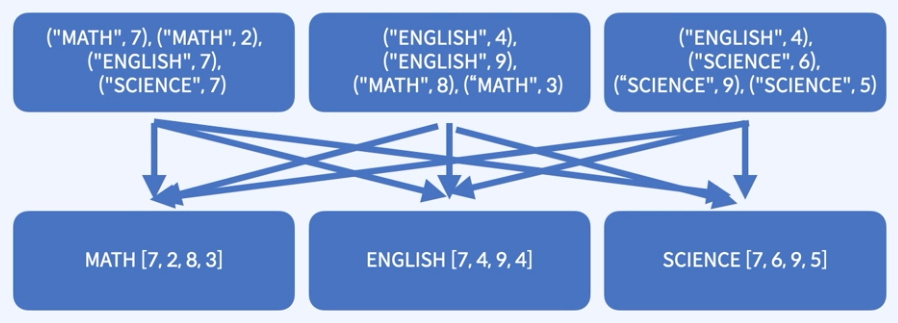

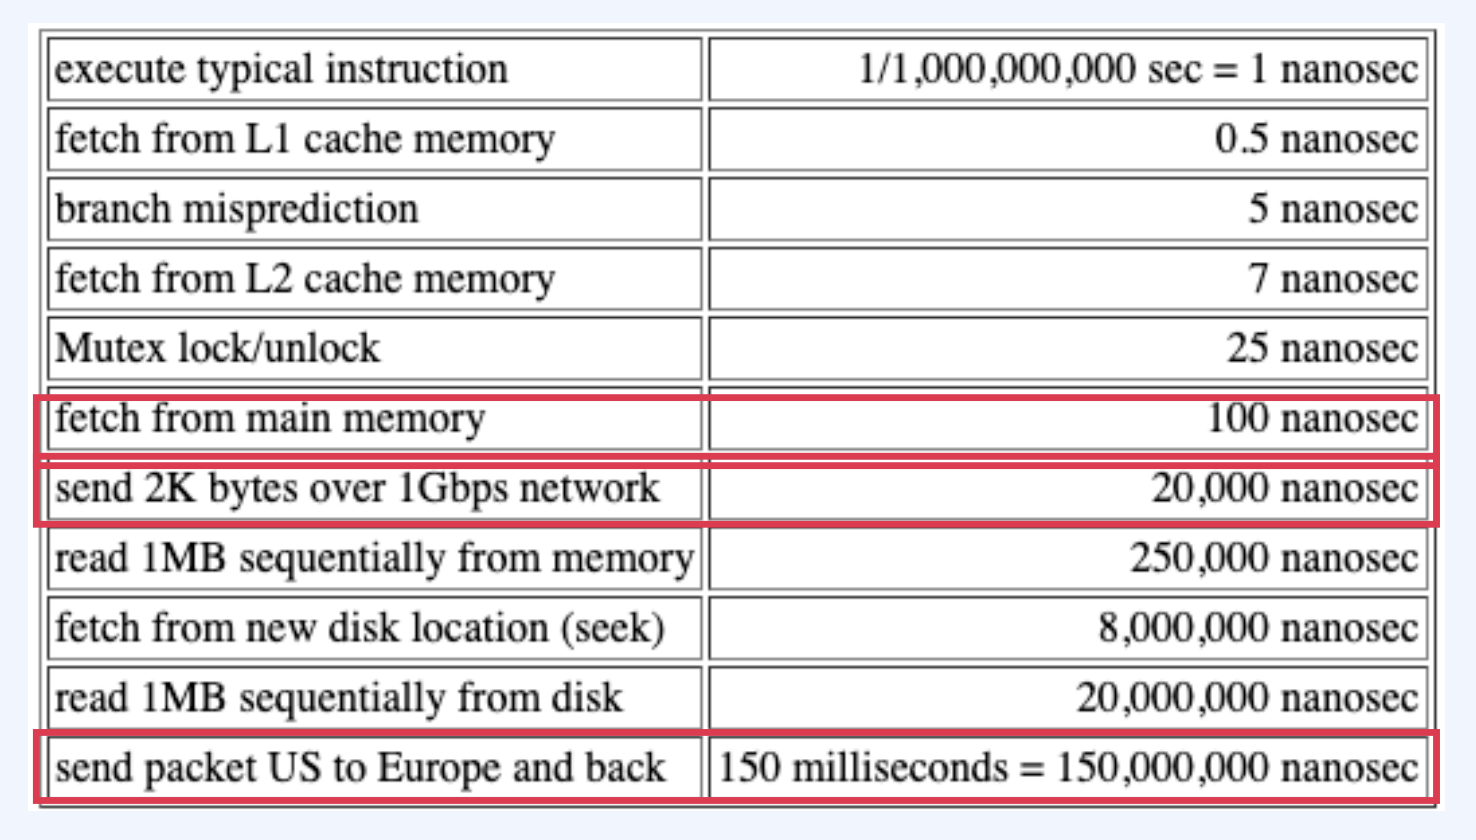

통신 속도를 보면 네트워크가 메모리와 디스크보다 느리기 때문에 주의해야 한다.

**셔플을 일으킬 수 있는 작업**

Join, leftOuterJoin, rightOuterJoin

GroupByKey

ReduceByKey

ComebineByKey

Distinct

Intersection

Repartition

Coalesce

**셔플의 발생**

셔플은 결과로 나오는 RDD가 원본 RDD의 다른 요소를 참조하거나 다른 RDD를 참조할 때 발생한다.

**파티셔너(Partitioner)를 이용한 성능 최적화**

파티셔닝을 이용해 네트워크 코스트를 최소화할 수 있다.

네트워크 코스트의 안좋은 예는 GroupByKeys + Reduce로 들 수 있다.

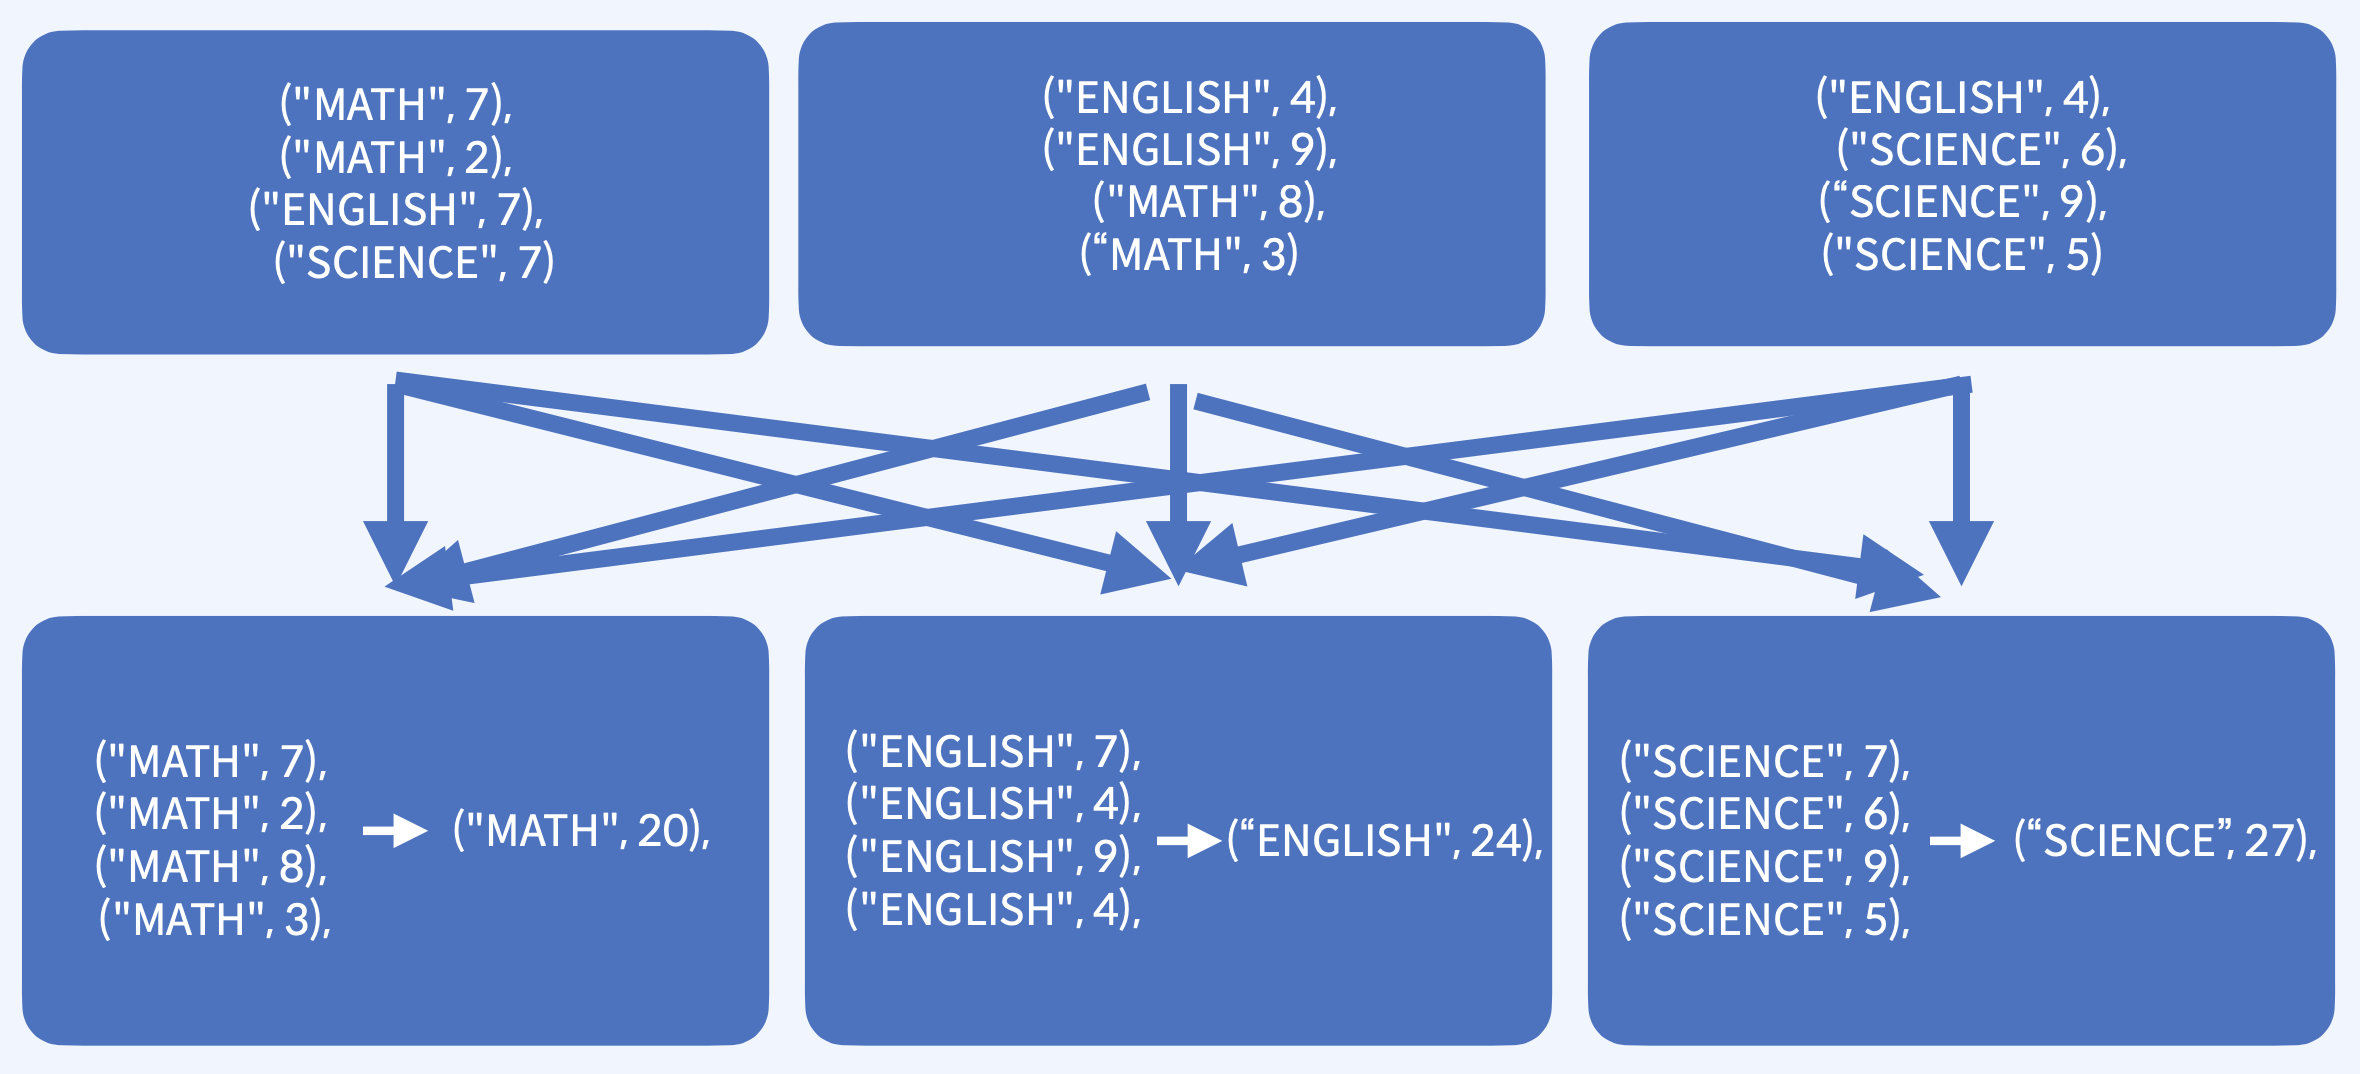

여러번의 셔플링이 일어나서 네트워크 코스트가 늘어나게 되고, 각각의 파티션에 따로 데이터를 모으게 된다.

최적화하기 위해 ReduceByKey를 진행한다.

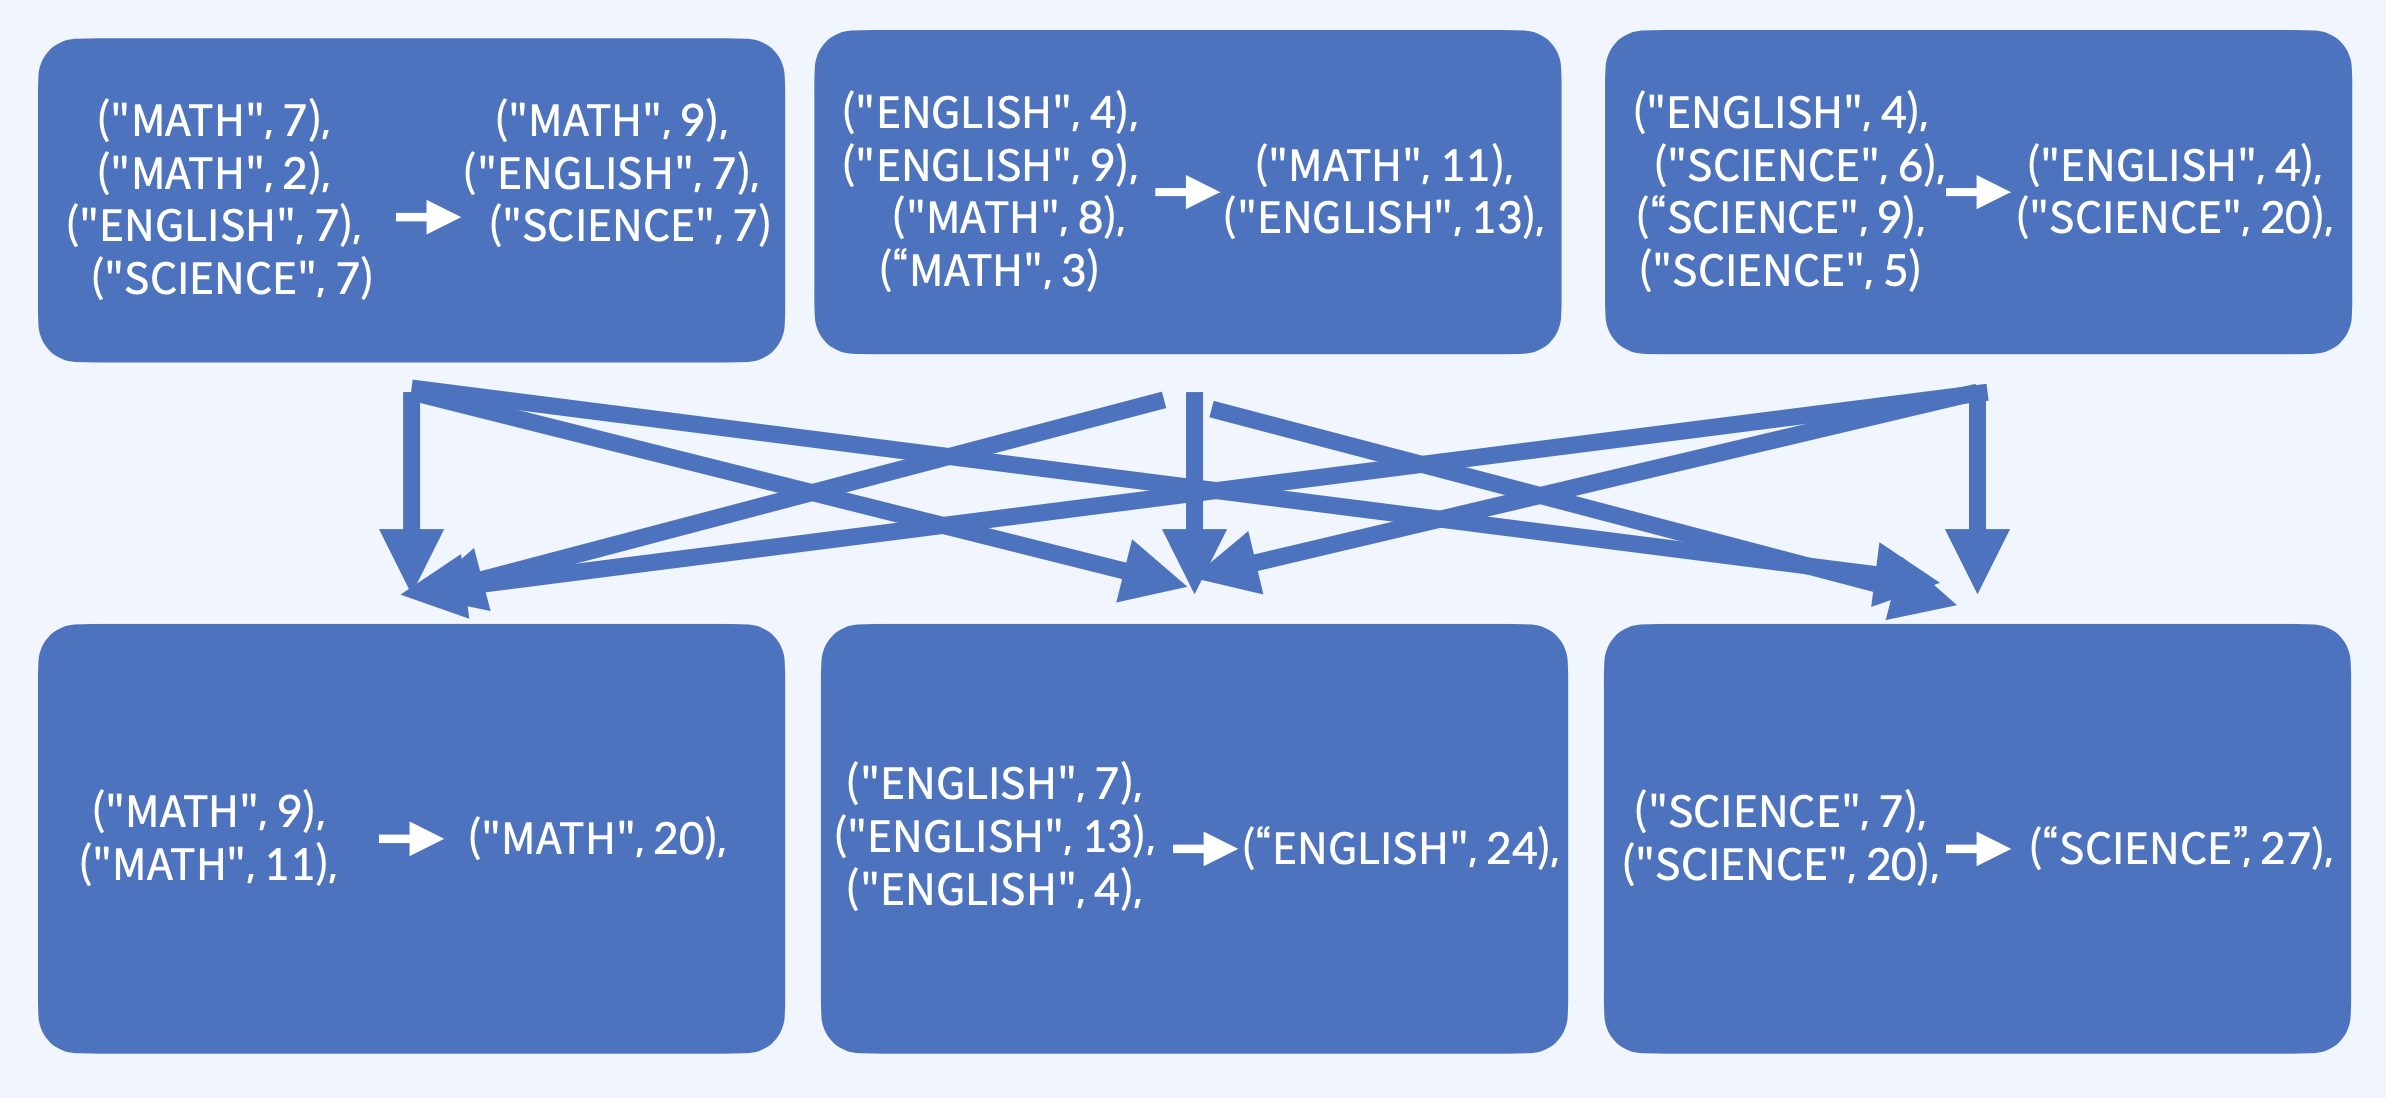

각각의 파티션에서 리듀스(Reduce)를 진행하기 때문에 데이터의 수가 굉장히 적어지고 자연스레 네트워크 코스트도 최적화된다.

셔플의 최소화

미리 파티션을 만들어 두고 캐싱(Cashing) 후 reduceByKey나 join을 실행하는 것이 좋다.

둘 다 파티션과 캐싱을 조합해서 최대한 로컬 환경에서 연산이 실행하도록하는 방식이다.

셔플을 최소화하여 10배의 성능 향상이 가능하다.

# **예제**

reduceByKey와 groupByKey를 비교한다.

둘의 결과는 같겠지만, 성능은 굉장한 차이가 난다.



```
(
    textRDD
    .flatMap(lambda line: line.split())
    .map(lambda word: (word, 1))
    .reduceByKey(lambda a, b: a + b)
)
```





```
(
    textRDD
    .flatMap(lambda line: line.split())
    .map(lambda word: (word, 1))
    .groupByKey()
    .map(lambda (w, couts): (w, sum(counts)))
)
```



**파티션의 목적**

데이터를 최대한 균일하게 퍼트리고 쿼리(query)가 같이 동작하는 데이터를 최대한 옆에 두어 검색 성능을 향상시키는 것이다.

파티션은 KV RDD일 때만 의미가 있다.

 일반 RDD는 어떤 값을 가져오든 처음부터 끝까지 검색해야 하기 때문에 파티셔닝을 잘하든 못하든 의미가 없다.

KV RDD에서 파티셔닝을 잘 하게 되면 키를 기준으로 값을 바로 찾을 수 있기 때문에 검색 성능을 향상시킬 수 있기 때문에 네트워크가 빨라진다.

**파티션의 특징**

RDD가 쪼개져서 여러 파티션에 저장된다.

하나의 파티션은 하나의 노드(서버)에 저장된다.

하나의 노드는 여러개의 파티션을 가질 수 있다.

파티션의 크기와 배치는 자유롭게 설정할 수 있고 성능에 큰 영향을 미친다.

KV RDD를 사용할 때만 의미가 있다.

스파크의 파티셔닝은 일반 프로그래밍에서 자료 구조를 선택하는 것과 비슷한 파급력이 있다.

# **파티션의 종류**

**Hash Partitoning**

이탤릭체 텍스트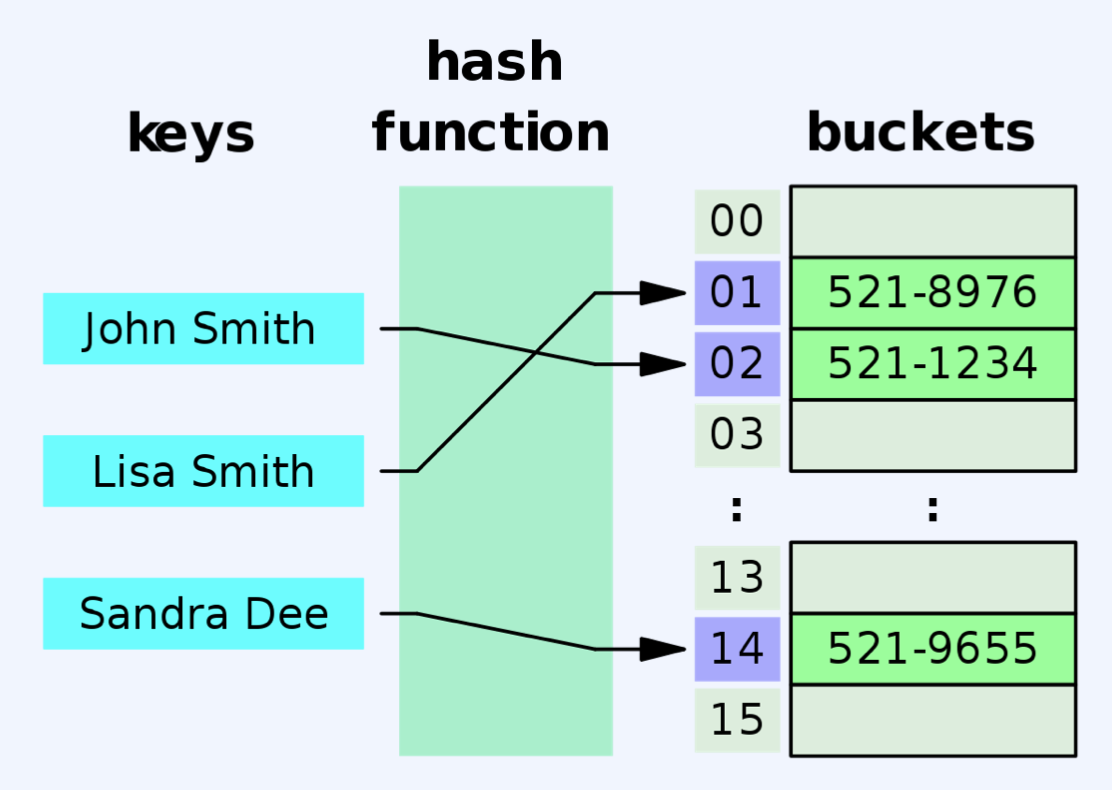

해시 파티셔닝은 데이터를 여러 파티션에 균일하게 분배하는 방식이다.

자료 구조의 딕셔너리와 유사한 형태이다.

키를 해시 함수를 이용해서 랜덤된 값으로 반환하여, 값을 키로 만들어 키를 기준으로 데이터를 저장하는 것이다. 그렇기에 균일하게 분배된다.

**단점**

만약 두 개의 파티션이 있는 상황에서,
짝수의 키만 있는 데이터셋에 해시 함수가 (x%2)라면 한 쪽 파티션만 사용하게 될 것이다.

Partition 1: [2, 4, 6, 8, 10, …]

Partition 2: []

위와 같아지면 파티션을 하는 의미가 없어지기 때문에 데이터셋과 해시 펑션을 잘 선택하는 것이 중요하다.

**Range Partitioning**

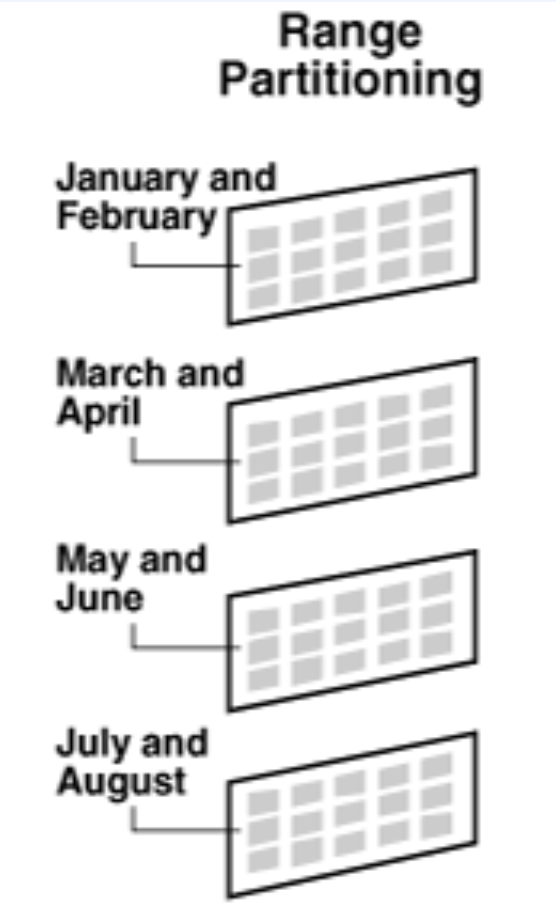

레인지 파티셔닝은 순서가 있는, (키의 순서에 따라, 키의 집합의 순서에 따라)정렬된 파티셔닝이다.

서비스의 쿼리 패턴이 날짜 위주면 일별 레인지 파티션을 고려해서 사용하면 데이터를 훨씬 빠르게 찾을 수 있다.

# **메모리와 디스크 파티션**

**디스크에서 파티션**

partitionBy()

보통 많이 사용되며, 사용자가 지정한 파티션을 가지는 RDD를 생성하는 함수이다.

In [8]:
from pyspark import SparkConf, SparkContext
sc = SparkContext()

In [9]:
pairs = sc.parallelize([1, 2, 3, 4, 2, 4, 1]).map(lambda x: (x, x))
pairs.collect()

[(1, 1), (2, 2), (3, 3), (4, 4), (2, 2), (4, 4), (1, 1)]

In [11]:
pairs.partitionBy(2, lambda x: x%2).glom().collect()
 # 해시 함수를 지정할 수도 있다. 파티션이 두 개로 나뉘어 진다 글롬: 파티션을 다 전시해주는 트랜스포메이션이다

[[(2, 2), (4, 4), (2, 2), (4, 4)], [(1, 1), (3, 3), (1, 1)]]

파티션을 만든 후에는 persist()로 저장을 해주어야 한다.

그렇지 않으면 다음 연산이 불릴 때마다 반복하게 된다.(셔플링이 반복적으로 일어난다.)

**메모리에서 파티션**

repartition()과 coalesce()는 둘 다 파티션의 갯수를 조절하는데 사용된다.

둘 다 셔플링을 동반하여 매우 비싼 작업이다
.
repartition()은 파티션의 크기를 줄이거나 늘리는 데 사용된다.

coalesce()는 파티션의 크기를 줄이는 데 사용된다.

연산 중 파티션을 만드는 작업들

Join (leftOuterJoin, rightOuterJoin)

groupByKey

reduceByKey

foldByKey

partitionBy

Sort

mapValues (parent)

flatMapValues (parent)

filter (parent)

여기서 parent의 의미는 위 RDD 파티션에서 정의가 되어 있으면 그대로 사용하게 된다.

위 작업 중 map과 flatMap이 포함되지 않는 이유는 키의 변형이 가능하기 때문이다.

키로 파티션이 되어있는데 변형되게 되면 파티션 자체가 망가진다.